In [111]:
import numpy as np
import dill
import matplotlib.pyplot as plt
import data_visualization as dv
import copy
import time
from pathlib import Path

import read_data_functions as rdf
import plot_functions as pf
from Optimal_Stopping_Object import ModelConstructor
from initializer import InitialThangs
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model Inputs

---
1. Switch Delay
2. Reward weighting
3. Altered SD 

        - Agent SD
        - Movement SD
        - Reaction SD
        - Gamble SD

---
NOTE: I'm using the data for guess sd. Haven't been able to really fit this with realistic parameters of the model. 

- This is likely due to people's intended decision time changing, whereas in the model, it is all around a single decision time
---

# Select Exp1 or Exp2


In [112]:
experiment = "Exp1"

# Initial Thangs


In [113]:
plt.style.use("cashaback_dark")
wheel = dv.ColorWheel()

# Get path and save path 
LOAD_PATH = Path(f"D:\OneDrive - University of Delaware - o365\Subject_Data\MatchPennies_Agent_{experiment}")
SAVE_PATH = f"D:\\OneDrive - University of Delaware - o365\\Subject_Data\\MatchPennies_Agent_{experiment}\\Figures\\"
it = InitialThangs(experiment)

# Pickle Data


In [114]:
if 'group' not in locals():
    group = rdf.generate_subject_object_v3(experiment,'All Trials')

# Create Models


## Set inputs for model

In [115]:
if experiment == "Exp1":
    rt    = np.nanmedian(np.nanmedian(group.movement_metrics.reaction_times, axis=1)) - 25
    rt_sd = np.nanmedian(np.nanstd(group.movement_metrics.reaction_times, axis=1))

elif experiment == "Exp2":
    rt    = np.nanmedian(np.nanmedian(group.movement_metrics.exp2_react_guess_reaction_time_split('react','only'), axis=1)) - 30
    rt_sd = np.nanmedian(np.nanstd(group.movement_metrics.reaction_times, axis=2))

mt                   = np.min(np.nanmedian(np.nanmedian(group.movement_metrics.movement_times('task'), axis=2), axis=0)) # Get movement time for the condition where they tried the hardest
mt_sd                = np.nanmedian(np.nanstd(group.movement_metrics.movement_times('task'), axis=1))
time_sd              = np.array([np.nanmedian(np.nanstd(group.movement_metrics.coincidence_reach_time, axis=1))] * it.num_blocks)
perc_wins_both_reach = np.nanmean(group.score_metrics.wins_when_both_reach(perc=True), axis=0)
guess_sd             = np.nanmedian(np.nanstd(group.react_guess_movement_metrics.movement_onset_times('guess'), axis=2), axis=0)
agent_sds            = np.nanmean(np.nanstd(group.raw_data.agent_task_leave_time, axis=2), axis=0)[:,np.newaxis]
agent_means          = np.nanmean(np.nanmean(group.raw_data.agent_task_leave_time, axis=2), axis=0)[:,np.newaxis]
guess_leave_time_sd  = np.nanmedian(np.nanstd(group.react_guess_movement_metrics.movement_onset_times('guess'),axis=2),axis=0)



#* Set numbers to change sd by 
agent_sd_change  = 150
rt_sd_change     = 15
mt_sd_change     = 25
timing_sd_change = 25

change_sd_list = [(agent_sd_change,0,0,0), (0,rt_sd_change,0,0), (0,0,mt_sd_change,0), (0,0,0,timing_sd_change)]
model_dict_keys = ['agent_sd', 'rt_sd', 'mt_sd', 'timing_sd']

## No Switch Delay, No Reward Altered, Change SDs

In [116]:
guess_switch_delay_true = 0
guess_switch_delay_expected = 0
#* Set win, incorrect, indecision reward if messing around with beta parameters
win_reward      = 1.0
indecision_cost = 0.0
incorrect_cost  = 0.0
############################################################################################
base_model_dict = {}
#* Loop through change_sd_list, altering each sd one by one with the above constants
for i,(agent_sd_change, rt_sd_change, mt_sd_change, timing_sd_change) in enumerate(change_sd_list):
    print(agent_sd_change, rt_sd_change, mt_sd_change, timing_sd_change)
    #* Add to agent sd 
    model  = ModelConstructor(
        experiment=experiment,
        num_blocks=it.num_blocks,
        num_timesteps=1800,
        BETA_ON=False,
        agent_means= np.array([agent_means,agent_means]),
        agent_sds= np.array([agent_sds,agent_sds + agent_sd_change]), #!
        reaction_time=np.array([rt, rt]),
        movement_time=np.array([mt, mt]),
        reaction_sd  =np.array([rt_sd, rt_sd - rt_sd_change]), #! Reducing these, aka the particiapnt thinks they are more certain than they are
        movement_sd  =np.array([mt_sd, mt_sd - mt_sd_change]),
        timing_sd    =np.array([time_sd, time_sd - timing_sd_change]),
        perc_wins_when_both_reach=perc_wins_both_reach,
        guess_switch_delay=np.array([[guess_switch_delay_true, guess_switch_delay_expected]]).T, # Designed like this for broadcasting reasons
        guess_sd     = np.array([guess_leave_time_sd,guess_leave_time_sd]), # This includes electromechanical delay sd and timing sd bc it's straight from data
        electromechanical_delay=np.array([[50, 50]]).T,
        switch_cost_exists=True,
        expected=True,
        win_reward=win_reward,
        incorrect_cost=incorrect_cost,
        indecision_cost=indecision_cost,
    )
    base_model_dict.update({model_dict_keys[i]:model})
    


150 0 0 0
0 15 0 0
0 0 25 0
0 0 0 25


## Unknown Switch Delay, NO Altered Reward, Changing SD

In [117]:
guess_switch_delay_true = 60 #! Changed to 60 from above
guess_switch_delay_expected = 0
#* Set win, incorrect, indecision reward if messing around with beta parameters
win_reward      = 1.0
indecision_cost = 0.0
incorrect_cost  = 0.0
############################################################################################
switch_delay_dict = {}
#* Loop through change_sd_list, altering each sd one by one with the above constants
for i,(agent_sd_change, rt_sd_change, mt_sd_change, timing_sd_change) in enumerate(change_sd_list):
    #* Add to agent sd 
    model  = ModelConstructor(
        experiment=experiment,
        num_blocks=it.num_blocks,
        num_timesteps=1800,
        BETA_ON=False,
        agent_means= np.array([agent_means,agent_means]),
        agent_sds= np.array([agent_sds,agent_sds + agent_sd_change]), #!
        reaction_time=np.array([rt, rt]),
        movement_time=np.array([mt, mt]),
        reaction_sd  =np.array([rt_sd, rt_sd - rt_sd_change]), #! Reducing these, aka the particiapnt thinks they are more certain than they are
        movement_sd  =np.array([mt_sd, mt_sd - mt_sd_change]),
        timing_sd    =np.array([time_sd, time_sd - timing_sd_change]),
        perc_wins_when_both_reach=perc_wins_both_reach,
        guess_switch_delay=np.array([[guess_switch_delay_true, guess_switch_delay_expected]]).T, # Designed like this for broadcasting reasons
        guess_sd     = np.array([guess_leave_time_sd,guess_leave_time_sd]), # This includes electromechanical delay sd and timing sd bc it's straight from data
        electromechanical_delay=np.array([[50, 50]]).T,
        switch_cost_exists=True,
        expected=True,
        win_reward=win_reward,
        incorrect_cost=incorrect_cost,
        indecision_cost=indecision_cost,
    )
    switch_delay_dict.update({model_dict_keys[i]:model})

## No Switch Delay, Altered Reward, Changing SD

In [118]:
guess_switch_delay_true = 0 #! Changed to 0 from above
guess_switch_delay_expected = 0
#* Set win, incorrect, indecision reward if messing around with beta parameters
win_reward      = 1.0
indecision_cost = 0.0
incorrect_cost  = -0.2 #! Changed to -0.2
#############################################################################################
altered_reward_dict = {}
#* Loop through change_sd_list, altering each sd one by one with the above constants
for i,(agent_sd_change, rt_sd_change, mt_sd_change, timing_sd_change) in enumerate(change_sd_list):
    #* Add to agent sd 
    model  = ModelConstructor(
        experiment=experiment,
        num_blocks=it.num_blocks,
        num_timesteps=1800,
        BETA_ON=False,
        agent_means= np.array([agent_means,agent_means]),
        agent_sds= np.array([agent_sds,agent_sds + agent_sd_change]), #!
        reaction_time=np.array([rt, rt]),
        movement_time=np.array([mt, mt]),
        reaction_sd  =np.array([rt_sd, rt_sd - rt_sd_change]), #! Reducing these, aka the particiapnt thinks they are more certain than they are
        movement_sd  =np.array([mt_sd, mt_sd - mt_sd_change]),
        timing_sd    =np.array([time_sd, time_sd - timing_sd_change]),
        perc_wins_when_both_reach=perc_wins_both_reach,
        guess_switch_delay=np.array([[guess_switch_delay_true, guess_switch_delay_expected]]).T, # Designed like this for broadcasting reasons
        guess_sd     = np.array([guess_leave_time_sd,guess_leave_time_sd]), # This includes electromechanical delay sd and timing sd bc it's straight from data
        electromechanical_delay=np.array([[50, 50]]).T,
        switch_cost_exists=True,
        expected=True,
        win_reward=win_reward,
        incorrect_cost=incorrect_cost,
        indecision_cost=indecision_cost,
    )
    altered_reward_dict.update({model_dict_keys[i]:model})

## Unknown Delay, Altered Reward, Changing SD

In [119]:
#
# * Set switch delay true and expected 
guess_switch_delay_true = 60 #! Changed to 60
guess_switch_delay_expected = 0
#* Set win, incorrect, indecision reward if messing around with beta parameters
win_reward      = 1.0
indecision_cost = 0.0
incorrect_cost  = -0.2 #! Changed to -0.2
############################################################################################
switch_delay_altered_reward_dict = {}
#* Loop through change_sd_list, altering each sd one by one with the above constants
for i,(agent_sd_change, rt_sd_change, mt_sd_change, timing_sd_change) in enumerate(change_sd_list):
    #* Add to agent sd 
    model  = ModelConstructor(
        experiment=experiment,
        num_blocks=it.num_blocks,
        num_timesteps=1800,
        BETA_ON=False,
        agent_means= np.array([agent_means,agent_means]),
        agent_sds= np.array([agent_sds,agent_sds + agent_sd_change]), #!
        reaction_time=np.array([rt, rt]),
        movement_time=np.array([mt, mt]),
        reaction_sd  =np.array([rt_sd, rt_sd - rt_sd_change]), #! Reducing these, aka the particiapnt thinks they are more certain than they are
        movement_sd  =np.array([mt_sd, mt_sd - mt_sd_change]),
        timing_sd    =np.array([time_sd, time_sd - timing_sd_change]),
        perc_wins_when_both_reach=perc_wins_both_reach,
        guess_switch_delay=np.array([[guess_switch_delay_true, guess_switch_delay_expected]]).T, # Designed like this for broadcasting reasons
        guess_sd     = np.array([guess_leave_time_sd,guess_leave_time_sd]), # This includes electromechanical delay sd and timing sd bc it's straight from data
        electromechanical_delay=np.array([[50, 50]]).T,
        switch_cost_exists=True,
        expected=True,
        win_reward=win_reward,
        incorrect_cost=incorrect_cost,
        indecision_cost=indecision_cost,
    )
    switch_delay_altered_reward_dict.update({model_dict_keys[i]:model})

# Plots

In [128]:
line_colors = [wheel.purple, wheel.white, wheel.rak_blue, wheel.rak_orange]

## No Switch, No Altered Reward

Text(0.5, 1.08, 'No Switch Delay, No Altered Reward')

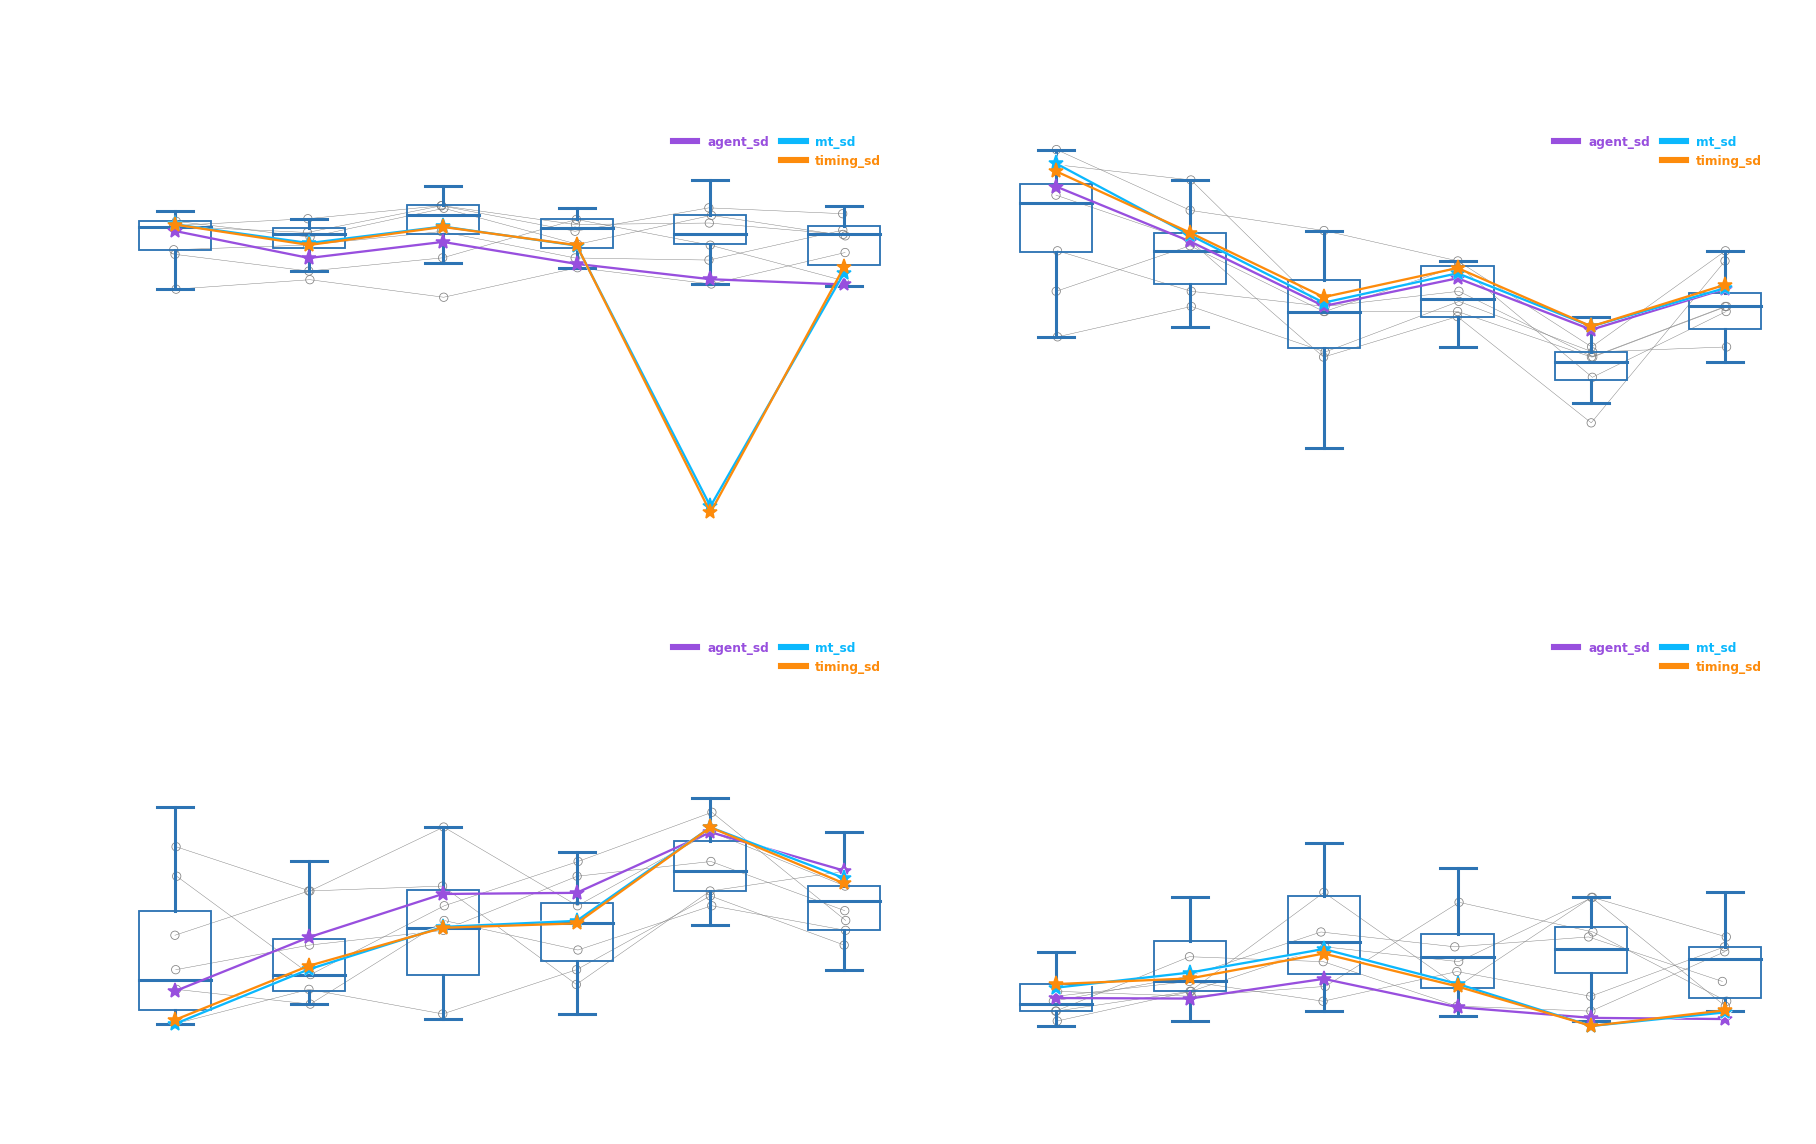

In [129]:
w,h = 16,9.2

mult_w, div_w = 0.053,2.3
div_h = 2.5
xlocs = np.linspace(0, w/div_w, num=len(it.trial_block_titles))
legend_fontsize = 8


fig = dv.Figure(figsize=(w,h),dpi=110)
ax1 = fig.add_panel(dim=(w*mult_w,    0.3, w/div_w, h/div_h))
ax2 = fig.add_panel(dim=(w/div_w+1.9, 0.3, w/div_w, h/div_h))
ax3 = fig.add_panel(dim=(w*mult_w,    4.9, w/div_w, h/div_h))
ax4 = fig.add_panel(dim=(w/div_w+1.9, 4.9, w/div_w, h/div_h))

if True:
    metric1                 = np.nanmedian(group.movement_metrics.movement_onset_times('task'), axis=2)
    model_data_list1  = [model.results.get_metric(model.player_behavior.wtd_leave_time,metric_type='true',decision_type='optimal') for model in base_model_dict.values()]
    ylocs1 = np.arange(400, 1601, 200)
    pf.multiple_models_boxplot_v2(
        ax=ax1,
        data=metric1,
        model_data_list=model_data_list1,
        labels=model_dict_keys,
        show_boxplot=True,
        colors=wheel.seth_blue,
        linestyles=["-"]*4,
        line_colors = line_colors,
        xlocs=xlocs,
        ylocs=ylocs1,
        xticklabels=it.trial_block_titles,
        xlabel=it.xlabel,
        ylabel='Time (ms)',
        title='Movement Onset Time',
        legend_fontsize=legend_fontsize
    )
    
if True:
    metric2 = group.score_metrics.score_metric('wins')/group.exp_info.num_task_trials*100
    model_data_list2  = [model.results.get_metric(model.score_metrics.prob_win,metric_type='true',decision_type='optimal')*100 for model in base_model_dict.values()]
    ylocs2 = np.arange(0, 101, 25)
    pf.multiple_models_boxplot_v2(
        ax=ax2,
        data=metric2,
        model_data_list=model_data_list2,
        labels=model_dict_keys,
        show_boxplot=True,
        colors=wheel.seth_blue,
        linestyles=["-"]*4,
        line_colors = line_colors,
        xlocs=xlocs,
        ylocs=ylocs2,
        xticklabels=it.trial_block_titles,
        xlabel=it.xlabel,
        ylabel='Wins (%)',
        title='Wins',
        legend_fontsize=legend_fontsize
    )
    
if True:
    metric3 = group.score_metrics.score_metric('incorrects')/group.exp_info.num_task_trials*100
    model_data_list3  = [model.results.get_metric(model.score_metrics.prob_incorrect,metric_type='true',decision_type='optimal')*100 for model in base_model_dict.values()]
    ylocs3 = np.arange(0, 101, 25)
    pf.multiple_models_boxplot_v2(
        ax=ax3,
        data=metric3,
        model_data_list=model_data_list3,
        labels=model_dict_keys,
        show_boxplot=True,
        colors=wheel.seth_blue,
        linestyles=["-"]*4,
        line_colors = line_colors,
        xlocs=xlocs,
        ylocs=ylocs3,
        xticklabels=it.trial_block_titles,
        xlabel=it.xlabel,
        ylabel='Incorrects (%)',
        title='Incorrects',
        legend_fontsize=legend_fontsize
    )
    
    
if True:
    metric4 = group.score_metrics.score_metric('indecisions')/group.exp_info.num_task_trials*100
    model_data_list4  = [model.results.get_metric(model.score_metrics.prob_indecision,metric_type='true',decision_type='optimal')*100 for model in base_model_dict.values()]
    ylocs4 = np.arange(0, 101, 25)
    pf.multiple_models_boxplot_v2(
        ax=ax4,
        data=metric4,
        model_data_list=model_data_list4,
        labels=model_dict_keys,
        show_boxplot=True,
        colors=wheel.seth_blue,
        linestyles=["-"]*4,
        line_colors = line_colors,
        xlocs=xlocs,
        ylocs=ylocs4,
        xticklabels=it.trial_block_titles,
        xlabel=it.xlabel,
        ylabel='Indecisions (%)',
        title='Indecisions',
        legend_fontsize=legend_fontsize
    )
    
plt.suptitle('No Switch Delay, No Altered Reward', y=1.08)

## Unknown Switch Delay, Altered Reward 

Text(0.5, 1.08, 'Unknown Switch Delay, No Altered Reward')

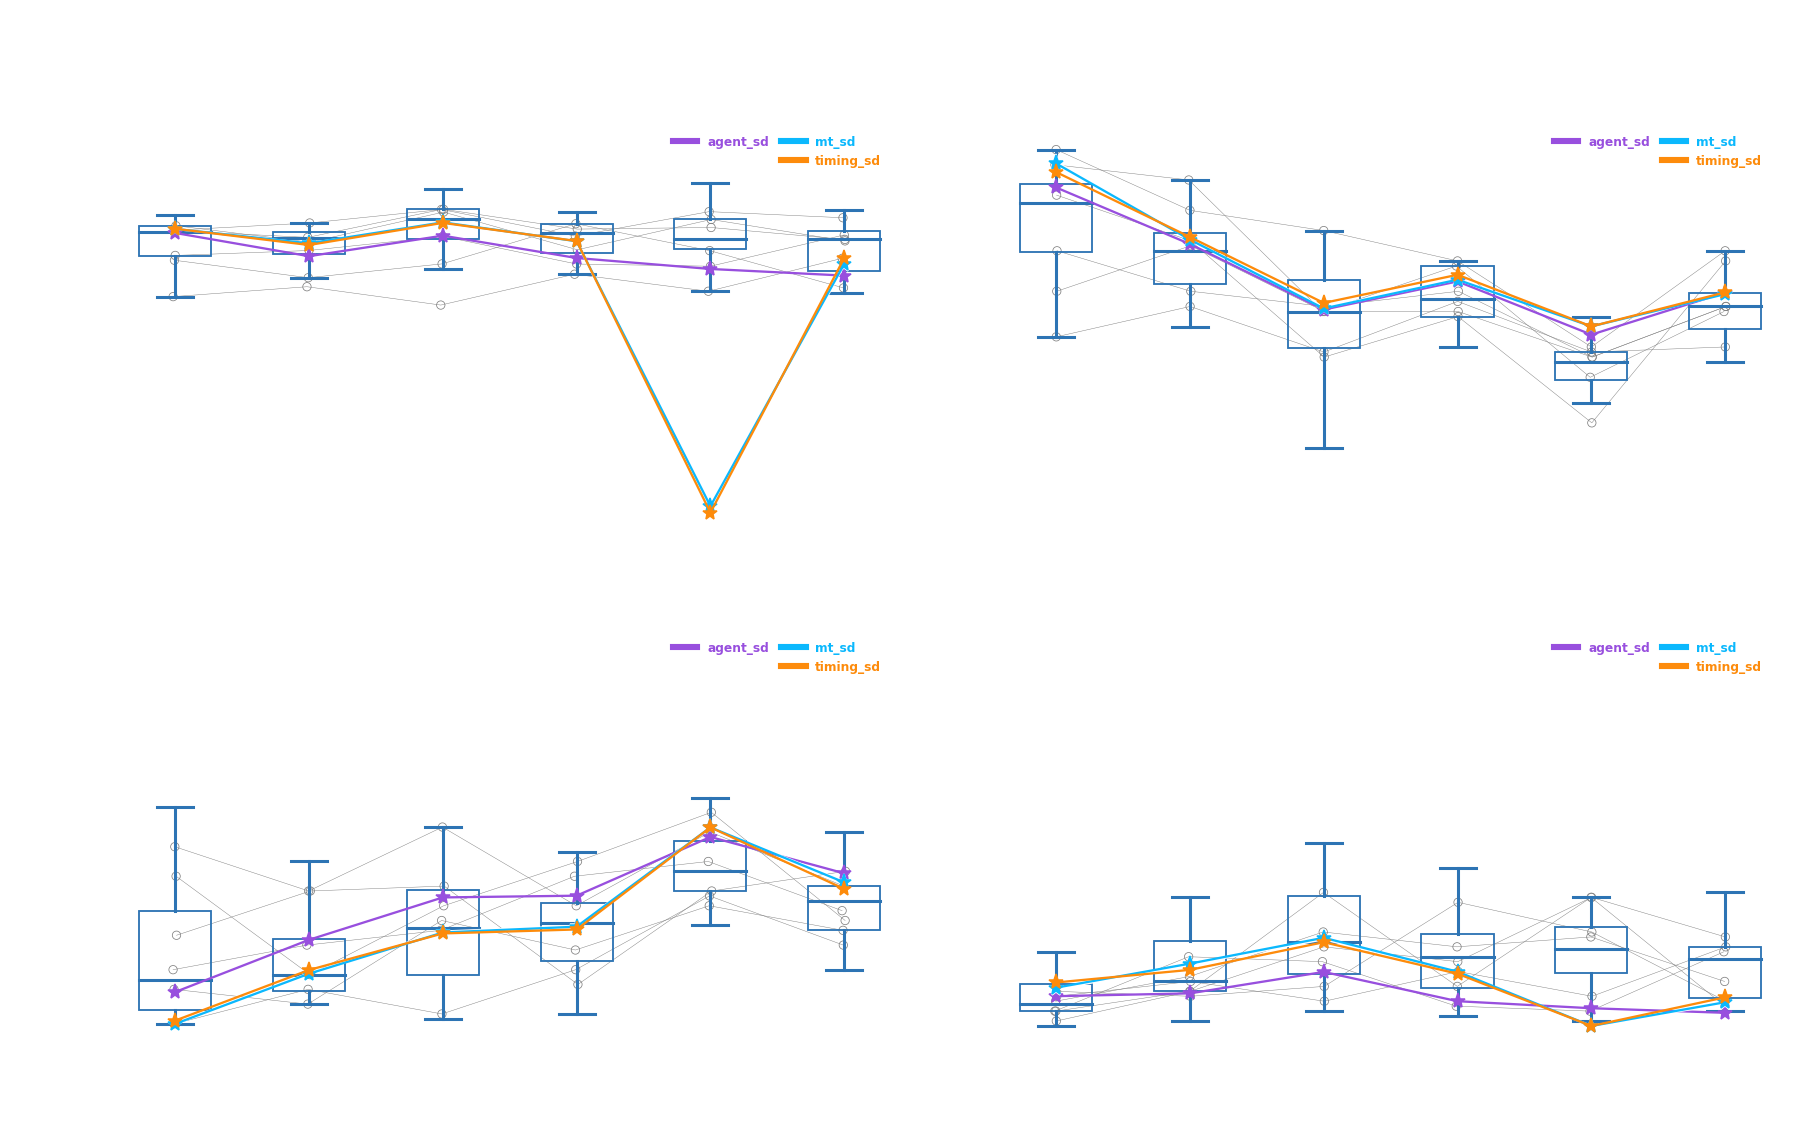

In [130]:
w,h = 16,9.2

mult_w, div_w = 0.053,2.3
div_h = 2.5
xlocs = np.linspace(0, w/div_w, num=len(it.trial_block_titles))
legend_fontsize = 8


fig = dv.Figure(figsize=(w,h),dpi=110)
ax1 = fig.add_panel(dim=(w*mult_w,    0.3, w/div_w, h/div_h))
ax2 = fig.add_panel(dim=(w/div_w+1.9, 0.3, w/div_w, h/div_h))
ax3 = fig.add_panel(dim=(w*mult_w,    4.9, w/div_w, h/div_h))
ax4 = fig.add_panel(dim=(w/div_w+1.9, 4.9, w/div_w, h/div_h))

if True:
    metric1                 = np.nanmedian(group.movement_metrics.movement_onset_times('task'), axis=2)
    model_data_list1  = [model.results.get_metric(model.player_behavior.wtd_leave_time,metric_type='true',decision_type='optimal') for model in switch_delay_dict.values()]
    ylocs1 = np.arange(400, 1601, 200)
    pf.multiple_models_boxplot_v2(
        ax=ax1,
        data=metric1,
        model_data_list=model_data_list1,
        labels=model_dict_keys,
        show_boxplot=True,
        colors=wheel.seth_blue,
        linestyles=["-"]*4,
        line_colors = line_colors,
        xlocs=xlocs,
        ylocs=ylocs1,
        xticklabels=it.trial_block_titles,
        xlabel=it.xlabel,
        ylabel='Time (ms)',
        title='Movement Onset Time',
        legend_fontsize=legend_fontsize
    )
    
if True:
    metric2 = group.score_metrics.score_metric('wins')/group.exp_info.num_task_trials*100
    model_data_list2  = [model.results.get_metric(model.score_metrics.prob_win,metric_type='true',decision_type='optimal')*100 for model in switch_delay_dict.values()]
    ylocs2 = np.arange(0, 101, 25)
    pf.multiple_models_boxplot_v2(
        ax=ax2,
        data=metric2,
        model_data_list=model_data_list2,
        labels=model_dict_keys,
        show_boxplot=True,
        colors=wheel.seth_blue,
        linestyles=["-"]*4,
        line_colors = line_colors,
        xlocs=xlocs,
        ylocs=ylocs2,
        xticklabels=it.trial_block_titles,
        xlabel=it.xlabel,
        ylabel='Wins (%)',
        title='Wins',
        legend_fontsize=legend_fontsize
    )
    
if True:
    metric3 = group.score_metrics.score_metric('incorrects')/group.exp_info.num_task_trials*100
    model_data_list3  = [model.results.get_metric(model.score_metrics.prob_incorrect,metric_type='true',decision_type='optimal')*100 for model in switch_delay_dict.values()]
    ylocs3 = np.arange(0, 101, 25)
    pf.multiple_models_boxplot_v2(
        ax=ax3,
        data=metric3,
        model_data_list=model_data_list3,
        labels=model_dict_keys,
        show_boxplot=True,
        colors=wheel.seth_blue,
        linestyles=["-"]*4,
        line_colors = line_colors,
        xlocs=xlocs,
        ylocs=ylocs3,
        xticklabels=it.trial_block_titles,
        xlabel=it.xlabel,
        ylabel='Incorrects (%)',
        title='Incorrects',
        legend_fontsize=legend_fontsize
    )
    
    
if True:
    metric4 = group.score_metrics.score_metric('indecisions')/group.exp_info.num_task_trials*100
    model_data_list4  = [model.results.get_metric(model.score_metrics.prob_indecision,metric_type='true',decision_type='optimal')*100 for model in switch_delay_dict.values()]
    ylocs4 = np.arange(0, 101, 25)
    pf.multiple_models_boxplot_v2(
        ax=ax4,
        data=metric4,
        model_data_list=model_data_list4,
        labels=model_dict_keys,
        show_boxplot=True,
        colors=wheel.seth_blue,
        linestyles=["-"]*4,
        line_colors = line_colors,
        xlocs=xlocs,
        ylocs=ylocs4,
        xticklabels=it.trial_block_titles,
        xlabel=it.xlabel,
        ylabel='Indecisions (%)',
        title='Indecisions',
        legend_fontsize=legend_fontsize
    )
    
plt.suptitle('Unknown Switch Delay, No Altered Reward', y=1.08)

## No Switch Delay, Altered Reward

Text(0.5, 1.08, 'Unknown Switch Delay, No Altered Reward')

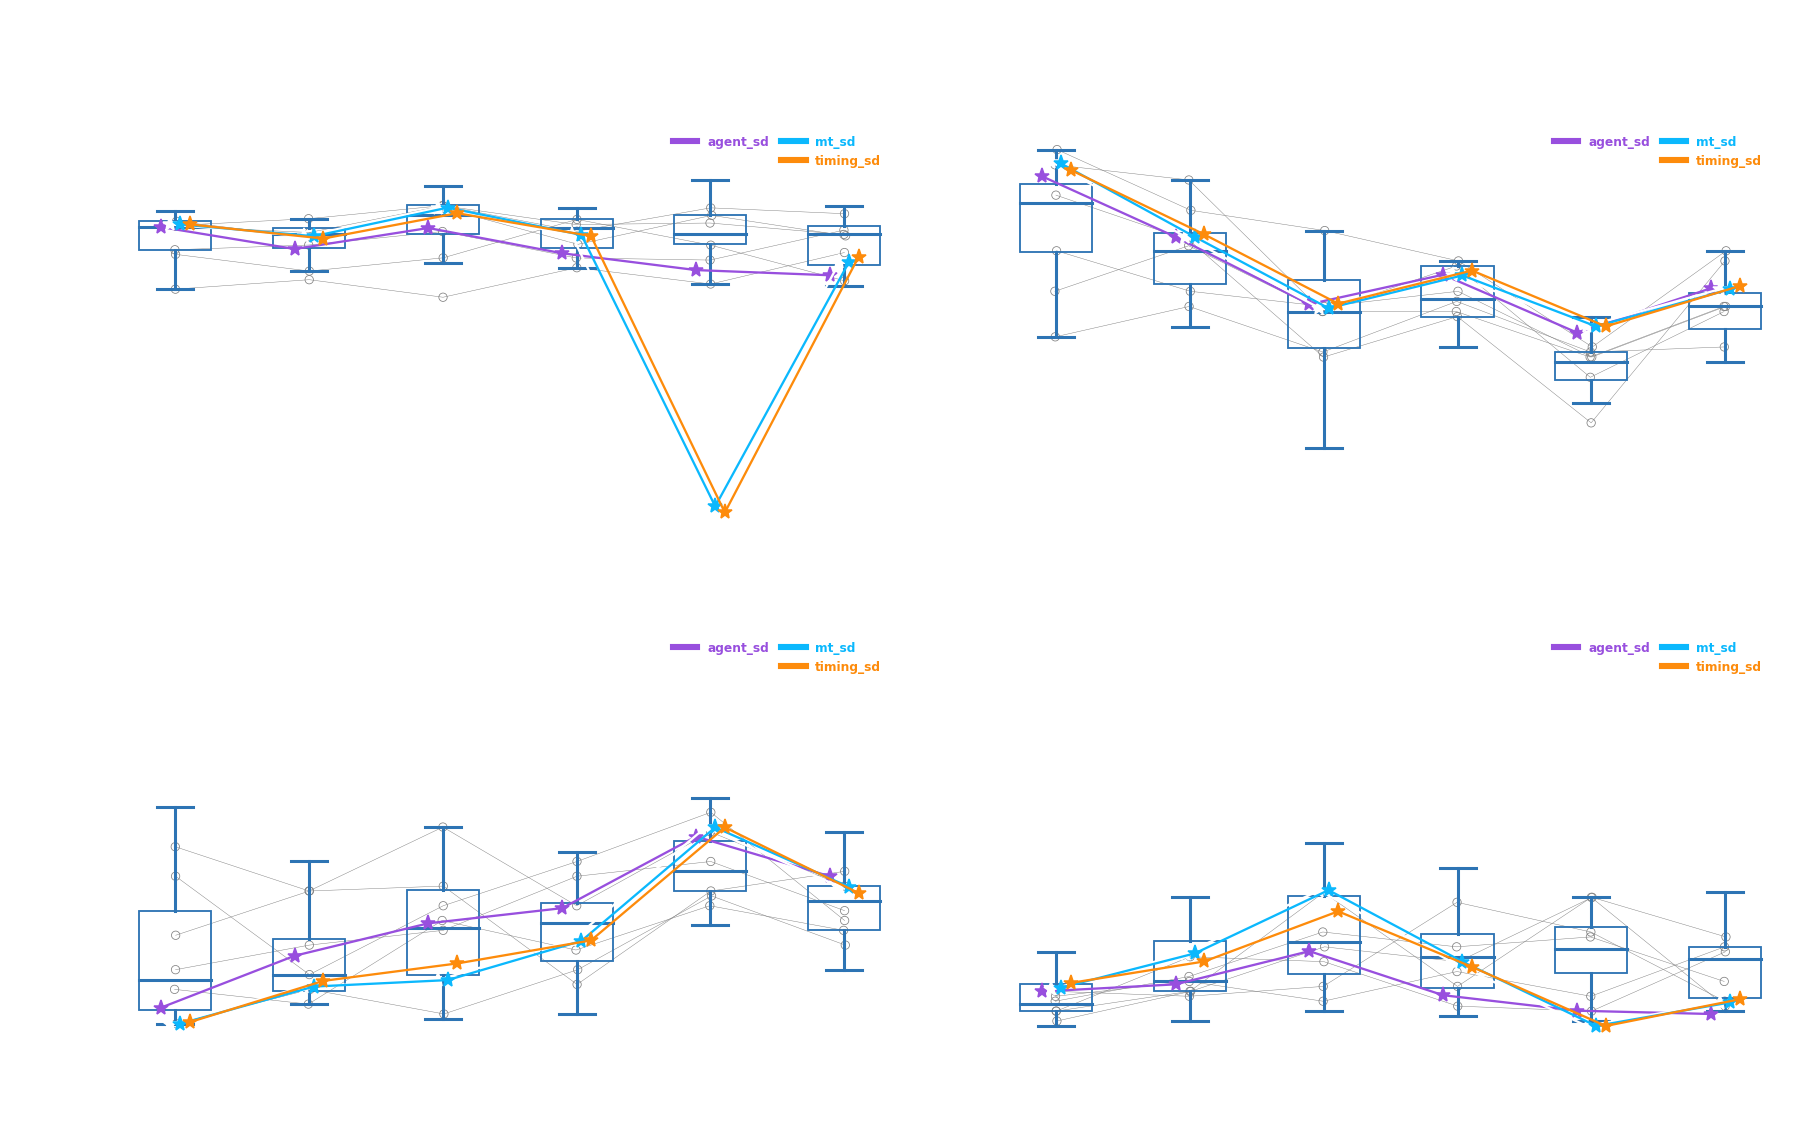

In [150]:
w,h = 16,9.2

mult_w, div_w = 0.053,2.3
div_h = 2.5
xlocs = np.linspace(0, w/div_w, num=len(it.trial_block_titles))
legend_fontsize = 8


fig = dv.Figure(figsize=(w,h),dpi=110)
ax1 = fig.add_panel(dim=(w*mult_w,    0.3, w/div_w, h/div_h))
ax2 = fig.add_panel(dim=(w/div_w+1.9, 0.3, w/div_w, h/div_h))
ax3 = fig.add_panel(dim=(w*mult_w,    4.9, w/div_w, h/div_h))
ax4 = fig.add_panel(dim=(w/div_w+1.9, 4.9, w/div_w, h/div_h))

if True:
    metric1                 = np.nanmedian(group.movement_metrics.movement_onset_times('task'), axis=2)
    model_data_list1  = [model.results.get_metric(model.player_behavior.wtd_leave_time,metric_type='true',decision_type='optimal') for model in altered_reward_dict.values()]
    ylocs1 = np.arange(400, 1601, 200)
    pf.multiple_models_boxplot_v2(
        ax=ax1,
        data=metric1,
        model_data_list=model_data_list1,
        labels=model_dict_keys,
        show_boxplot=True,
        colors=wheel.seth_blue,
        linestyles=["-"]*4,
        line_colors = line_colors,
        xlocs=xlocs,
        ylocs=ylocs1,
        xticklabels=it.trial_block_titles,
        xlabel=it.xlabel,
        ylabel='Time (ms)',
        title='Movement Onset Time',
        legend_fontsize=legend_fontsize
    )
    
if True:
    metric2 = group.score_metrics.score_metric('wins')/group.exp_info.num_task_trials*100
    model_data_list2  = [model.results.get_metric(model.score_metrics.prob_win,metric_type='true',decision_type='optimal')*100 for model in altered_reward_dict.values()]
    ylocs2 = np.arange(0, 101, 25)
    pf.multiple_models_boxplot_v2(
        ax=ax2,
        data=metric2,
        model_data_list=model_data_list2,
        labels=model_dict_keys,
        show_boxplot=True,
        colors=wheel.seth_blue,
        linestyles=["-"]*4,
        line_colors = line_colors,
        xlocs=xlocs,
        ylocs=ylocs2,
        xticklabels=it.trial_block_titles,
        xlabel=it.xlabel,
        ylabel='Wins (%)',
        title='Wins',
        legend_fontsize=legend_fontsize
    )
    
if True:
    metric3 = group.score_metrics.score_metric('incorrects')/group.exp_info.num_task_trials*100
    model_data_list3  = [model.results.get_metric(model.score_metrics.prob_incorrect,metric_type='true',decision_type='optimal')*100 for model in altered_reward_dict.values()]
    ylocs3 = np.arange(0, 101, 25)
    pf.multiple_models_boxplot_v2(
        ax=ax3,
        data=metric3,
        model_data_list=model_data_list3,
        labels=model_dict_keys,
        show_boxplot=True,
        colors=wheel.seth_blue,
        linestyles=["-"]*4,
        line_colors = line_colors,
        xlocs=xlocs,
        ylocs=ylocs3,
        xticklabels=it.trial_block_titles,
        xlabel=it.xlabel,
        ylabel='Incorrects (%)',
        title='Incorrects',
        legend_fontsize=legend_fontsize
    )
    
    
if True:
    metric4 = group.score_metrics.score_metric('indecisions')/group.exp_info.num_task_trials*100
    model_data_list4  = [model.results.get_metric(model.score_metrics.prob_indecision,metric_type='true',decision_type='optimal')*100 for model in altered_reward_dict.values()]
    ylocs4 = np.arange(0, 101, 25)
    pf.multiple_models_boxplot_v2(
        ax=ax4,
        data=metric4,
        model_data_list=model_data_list4,
        labels=model_dict_keys,
        show_boxplot=True,
        colors=wheel.seth_blue,
        linestyles=["-"]*4,
        line_colors = line_colors,
        xlocs=xlocs,
        ylocs=ylocs4,
        xticklabels=it.trial_block_titles,
        xlabel=it.xlabel,
        ylabel='Indecisions (%)',
        title='Indecisions',
        legend_fontsize=legend_fontsize
    )
    
plt.suptitle('Unknown Switch Delay, No Altered Reward', y=1.08)

In [138]:
line_colors[]

'#FFFFFF'

In [136]:
wheel.white

'#FFFFFF'

model_data_list